## Try and initialize better

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")


from tqdm.auto import tqdm
from stabnode.utils import set_global_seed
from data.budworm import simulate_trials, budworm_steady_states


seed = 1234
set_global_seed(seed=seed)
device = 'cpu'
folder = "figures"
savefigs = True

In [2]:
k=8.5

In [3]:
xs_traj = []
ts = []

x0s = np.linspace(0.1,10,51)
for x0 in x0s:
    budworm_trial =simulate_trials([k],x0, dt=0.1,r=0.56,eps=1e-3,buffer=1e-1,t_max=400,n_points=501, show_progress=False)
    xs_traj.append(budworm_trial.x_vals[0])
    ts.append(budworm_trial.t_vals[0])

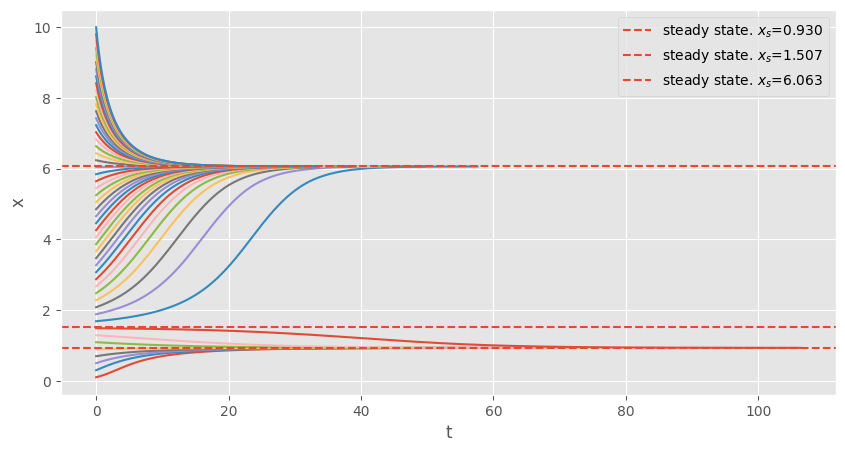

In [4]:
# expected steady states for fixed k and r
steady_states = budworm_steady_states(k,r=0.56)

plt.figure(figsize=(10,5))
for ti, xi in zip(ts, xs_traj):
    plt.plot(ti,xi)
for x_steady_state in steady_states:
    plt.axhline(x_steady_state, linestyle='--',label=rf"steady state. $x_s$={x_steady_state:.3f}")
plt.xlabel("t")
plt.ylabel("x")
plt.legend()
if savefigs:
    name = f"trajectories_k_{k:.4f}.pdf"
    plt.savefig(folder + "/"+name)
plt.show()

# True $f$ and $g$

In [5]:
from data.budworm import f_true, g_true

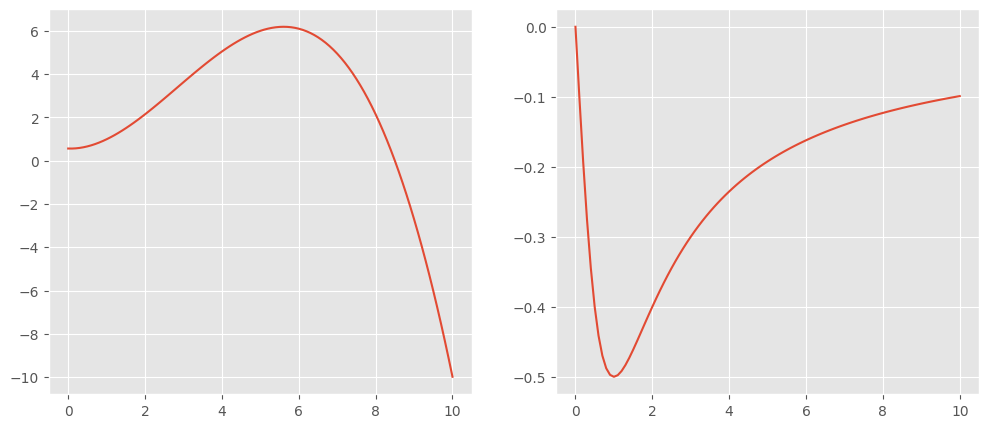

In [6]:
x_lin = np.linspace(0,10,101)

f_true_arr = f_true(x_lin)
g_true_arr = g_true(x_lin, k, r=0.56)


fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(x_lin, g_true_arr)
ax2.plot(x_lin, f_true_arr)
plt.show()

In [7]:
g_true_arr.min(), g_true_arr.max(), f_true_arr.min(), f_true_arr.max()

(-9.981176470588235, 6.1826635294117676, -0.5, -0.0)

In [8]:
from stabnode.node import FeluSigmoid, GeluSigmoid
import torch

In [9]:
x_lin_torch = torch.tensor(x_lin, dtype=torch.float32, device=device)

## train models & save models

In [10]:
import torch.nn as nn

In [11]:
g = GeluSigmoid(
    dim_in=1+1, # input is x dim + k dim
    dim_out=1,
    hidden_dim=8,
    lower_bound=-10,
    upper_bound=6.2
).to(device)

In [12]:
g_epochs = 20000
lr = 1e-2
show_progress = True
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(g.parameters()), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',factor=0.1,patience=10)
scheduler = None
print_every = 200


In [13]:
xs = x_lin_torch.to(device)  

g_true_torch = torch.tensor(g_true_arr, dtype=torch.float32, device=device)
k_torch = torch.tensor(k, dtype=torch.float32, device=device).reshape(-1, 1)


losses = []
lrs = []

g.train()
for epoch in tqdm(range(g_epochs)):
    opt.zero_grad()

    # Forward pass in batch
    g_pred =torch.cat([g(torch.tensor([[xi]],dtype=torch.float32),k_torch).reshape(-1) for xi in xs])

    # Loss
    loss = loss_criteria(g_true_torch, g_pred)

    # Backward + step
    loss.backward()
    opt.step()

    # Record
    epoch_loss = loss.item()
    if scheduler is not None:
        scheduler.step(epoch_loss)
    cur_lr = opt.param_groups[0]['lr']
    lrs.append(cur_lr)
    losses.append(epoch_loss)
    if epoch <= 5 or epoch % print_every ==0 or epoch == g_epochs-1:
        print(f"epoch {epoch}. Loss = {epoch_loss:.10f}. lr = {cur_lr:.10f}.")


  0%|          | 0/20000 [00:00<?, ?it/s]

epoch 0. Loss = 48.2369804382. lr = 0.0100000000.
epoch 1. Loss = 39.1441802979. lr = 0.0100000000.
epoch 2. Loss = 31.5757255554. lr = 0.0100000000.
epoch 3. Loss = 25.6835308075. lr = 0.0100000000.
epoch 4. Loss = 21.4140892029. lr = 0.0100000000.
epoch 5. Loss = 18.5534210205. lr = 0.0100000000.
epoch 200. Loss = 0.5279998183. lr = 0.0100000000.
epoch 400. Loss = 0.3052880168. lr = 0.0100000000.
epoch 600. Loss = 0.2712062895. lr = 0.0100000000.
epoch 800. Loss = 0.1856186241. lr = 0.0100000000.
epoch 1000. Loss = 0.1166885644. lr = 0.0100000000.
epoch 1200. Loss = 0.0868941545. lr = 0.0100000000.
epoch 1400. Loss = 0.0799841285. lr = 0.0100000000.
epoch 1600. Loss = 0.0768143162. lr = 0.0100000000.
epoch 1800. Loss = 0.0740601271. lr = 0.0100000000.
epoch 2000. Loss = 0.0716725513. lr = 0.0100000000.
epoch 2200. Loss = 0.0694121793. lr = 0.0100000000.
epoch 2400. Loss = 0.0672502220. lr = 0.0100000000.
epoch 2600. Loss = 0.0651732907. lr = 0.0100000000.
epoch 2800. Loss = 0.0631586

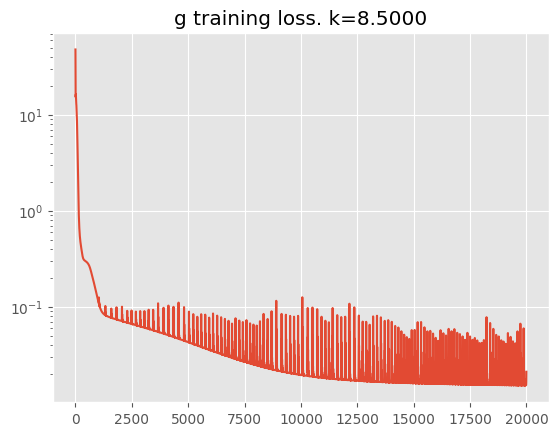

In [14]:
plt.plot(losses)
plt.yscale("log")
plt.title(f"g training loss. k={k:.4f}")
if savefigs:
    name = f"g_loss_k_{k:.4f}_epochs_{g_epochs}.pdf"
    plt.savefig(folder + "/"+name)
plt.show()

### save trained $g$ model

In [15]:
import copy

def save_initialized_model(term: FeluSigmoid | GeluSigmoid, save_path: str):
    device = next(term.parameters()).device.type

    term_args = term.args

    if device == "cpu":
        states = term.state_dict()
    else:
        term_copy = copy.deepcopy(term).to('cpu')

        states = term_copy.state_dict()
    
    states_and_args = {
        "state_dict": states,
        "kwargs": term_args
    } 
    
    torch.save(states_and_args, save_path)

In [16]:
save_path = f"g_term_k_{k:.4f}_epochs_{g_epochs}.pt"
save_initialized_model(g,save_path)

### Try loading model 

In [17]:
g_config = torch.load(save_path, map_location=device,weights_only=False)

g = GeluSigmoid(**g_config["kwargs"])

g.load_state_dict(g_config["state_dict"])

<All keys matched successfully>

In [18]:
g_eval = g.eval()

with torch.no_grad():
    k_torch = torch.tensor(k,dtype=torch.float32).reshape(-1,1)
    g_pred =torch.cat([g_eval(torch.tensor([[xi]],dtype=torch.float32),k_torch).reshape(-1) for xi in x_lin_torch])

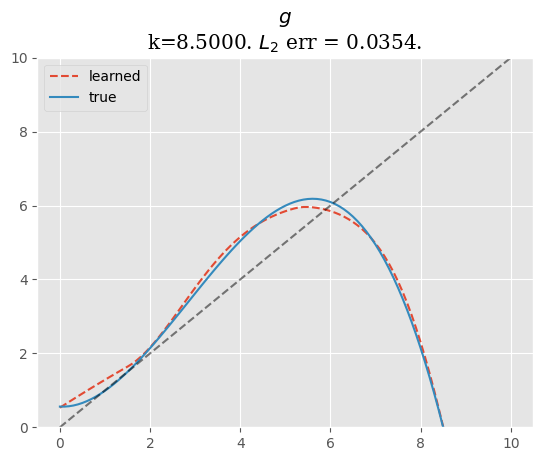

In [19]:
plt.plot(x_lin_torch.detach(),g_pred, linestyle='--', label="learned")
plt.plot(x_lin, g_true_arr, label='true')
plt.plot(x_lin,x_lin, linestyle='--',alpha=0.5,c='black')
plt.ylim(0,10)

err = np.linalg.norm(g_true_arr - g_pred.numpy()) / np.linalg.norm(g_true_arr)

plt.legend()
plt.title(rf"$g$"+"\n"+rf"k={k:.4f}. $L_2$ err = {err:.4f}. ", family='serif')
if savefigs:
    name = f"g_learned_k_{k:.4f}_epochs_{g_epochs}_alt.pdf"
    plt.savefig(folder + "/"+name)
plt.show()

## Learn f

In [20]:
f = FeluSigmoid(
    dim_in=1,
    dim_out=1,
    hidden_dim=8,
    lower_bound=-.5,
    upper_bound=0
).to(device)

In [21]:
f_epochs = 10000
lr = 1e-2
show_progress = True
solve_method = 'tsit5'
loss_criteria = nn.MSELoss()
opt = torch.optim.Adam(list(f.parameters()), lr = lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt,mode='min',factor=0.1,patience=10)
scheduler = None
print_every = 200

In [22]:
xs = x_lin_torch.to(device)  

f_true_torch = torch.tensor(f_true_arr, dtype=torch.float32, device=device)


losses = []
lrs = []

f.train()
for epoch in tqdm(range(f_epochs)):
    opt.zero_grad()

    # Forward pass in batch
    # g_pred =torch.cat([g(torch.tensor([[xi]],dtype=torch.float32),k_torch).reshape(-1) for xi in xs])

    f_pred = [f(xi.reshape(-1,1)).reshape(-1) for xi in xs]
    f_pred = torch.cat(f_pred)

    # Loss
    loss = loss_criteria(f_true_torch, f_pred)

    # Backward + step
    loss.backward()
    opt.step()

    # Record
    epoch_loss = loss.item()
    if scheduler is not None:
        scheduler.step(epoch_loss)
    cur_lr = opt.param_groups[0]['lr']
    lrs.append(cur_lr)
    losses.append(epoch_loss)
    if epoch <= 5 or epoch % print_every ==0 or epoch == f_epochs-1:
        print(f"epoch {epoch}. Loss = {epoch_loss:.10f}. lr = {cur_lr:.10f}.")

  0%|          | 0/10000 [00:00<?, ?it/s]

epoch 0. Loss = 0.0197109729. lr = 0.0100000000.
epoch 1. Loss = 0.0183980744. lr = 0.0100000000.
epoch 2. Loss = 0.0174337216. lr = 0.0100000000.
epoch 3. Loss = 0.0166786481. lr = 0.0100000000.
epoch 4. Loss = 0.0160487778. lr = 0.0100000000.
epoch 5. Loss = 0.0154743828. lr = 0.0100000000.
epoch 200. Loss = 0.0028644495. lr = 0.0100000000.
epoch 400. Loss = 0.0002285333. lr = 0.0100000000.
epoch 600. Loss = 0.0000762970. lr = 0.0100000000.
epoch 800. Loss = 0.0000667596. lr = 0.0100000000.
epoch 1000. Loss = 0.0000620897. lr = 0.0100000000.
epoch 1200. Loss = 0.0000571894. lr = 0.0100000000.
epoch 1400. Loss = 0.0000500705. lr = 0.0100000000.
epoch 1600. Loss = 0.0000420079. lr = 0.0100000000.
epoch 1800. Loss = 0.0000366986. lr = 0.0100000000.
epoch 2000. Loss = 0.0000325938. lr = 0.0100000000.
epoch 2200. Loss = 0.0000292881. lr = 0.0100000000.
epoch 2400. Loss = 0.0000266370. lr = 0.0100000000.
epoch 2600. Loss = 0.0000244454. lr = 0.0100000000.
epoch 2800. Loss = 0.0000226205. l

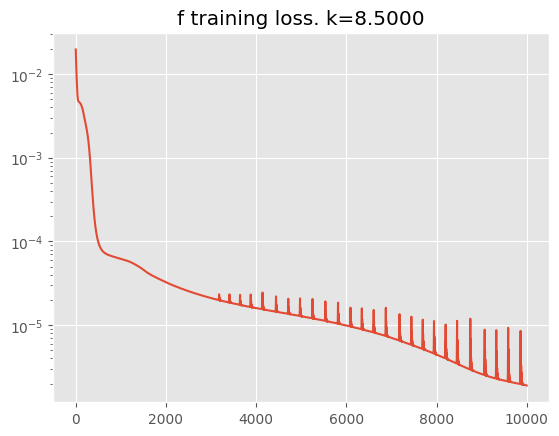

In [23]:
plt.plot(losses)
plt.yscale("log")
plt.title(f"f training loss. k={k:.4f}")
if savefigs:
    name = f"f_loss_k_{k:.4f}_epochs_{f_epochs}.pdf"
    plt.savefig(folder + "/"+name)
plt.show()

### save $f$ model

In [24]:
save_path = f"f_term_k_{k:.4f}_epochs_{f_epochs}.pt"
save_initialized_model(f,save_path)

In [25]:
f_config = torch.load(save_path, map_location=device,weights_only=False)

f = FeluSigmoid(**f_config["kwargs"])

f.load_state_dict(f_config["state_dict"])

<All keys matched successfully>

In [26]:
f_eval = f.eval()

with torch.no_grad():
    f_pred = [f_eval(xi.reshape(-1,1)).reshape(-1) for xi in x_lin_torch]
    f_pred = torch.cat(f_pred)

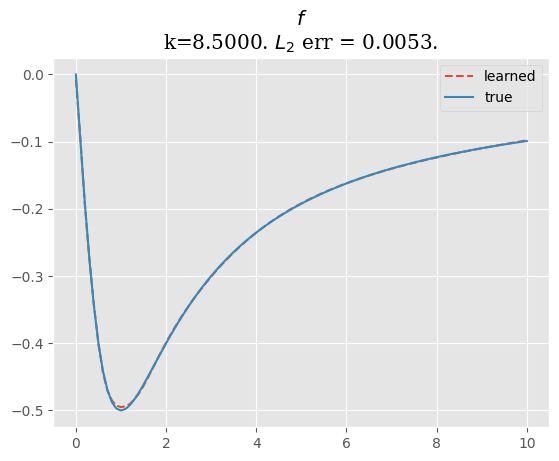

In [27]:
plt.plot(x_lin_torch.detach(),f_pred, linestyle='--',label='learned')
plt.plot(x_lin, f_true_arr,label='true')
err = np.linalg.norm(f_true_arr - f_pred.numpy()) / np.linalg.norm(f_true_arr)
plt.legend()
plt.title(rf"$f$"+"\n"+rf"k={k:.4f}. $L_2$ err = {err:.4f}. ", family='serif')
if savefigs:
    name = f"f_learned_k_{k:.4f}_f_epochs_{f_epochs}.pdf"
    plt.savefig(folder + "/"+name)
plt.show()

## Ensure that `torchode.sovle_ivp` actually solves correct trajectories

In [28]:
from torchode import solve_ivp
from stabnode.node import StabNODE
from stabnode.data import TrialsDataset

In [29]:
model_eval = StabNODE(f_eval, g_eval)

In [30]:
xs_torch = [torch.tensor(xi,dtype=torch.float32,device=device) for xi in xs_traj]
ts_torch = [torch.tensor(ti,dtype=torch.float32,device=device) for ti in ts]

train_dataset = TrialsDataset(xs_torch,ts_torch)

  0%|          | 0/51 [00:00<?, ?it/s]

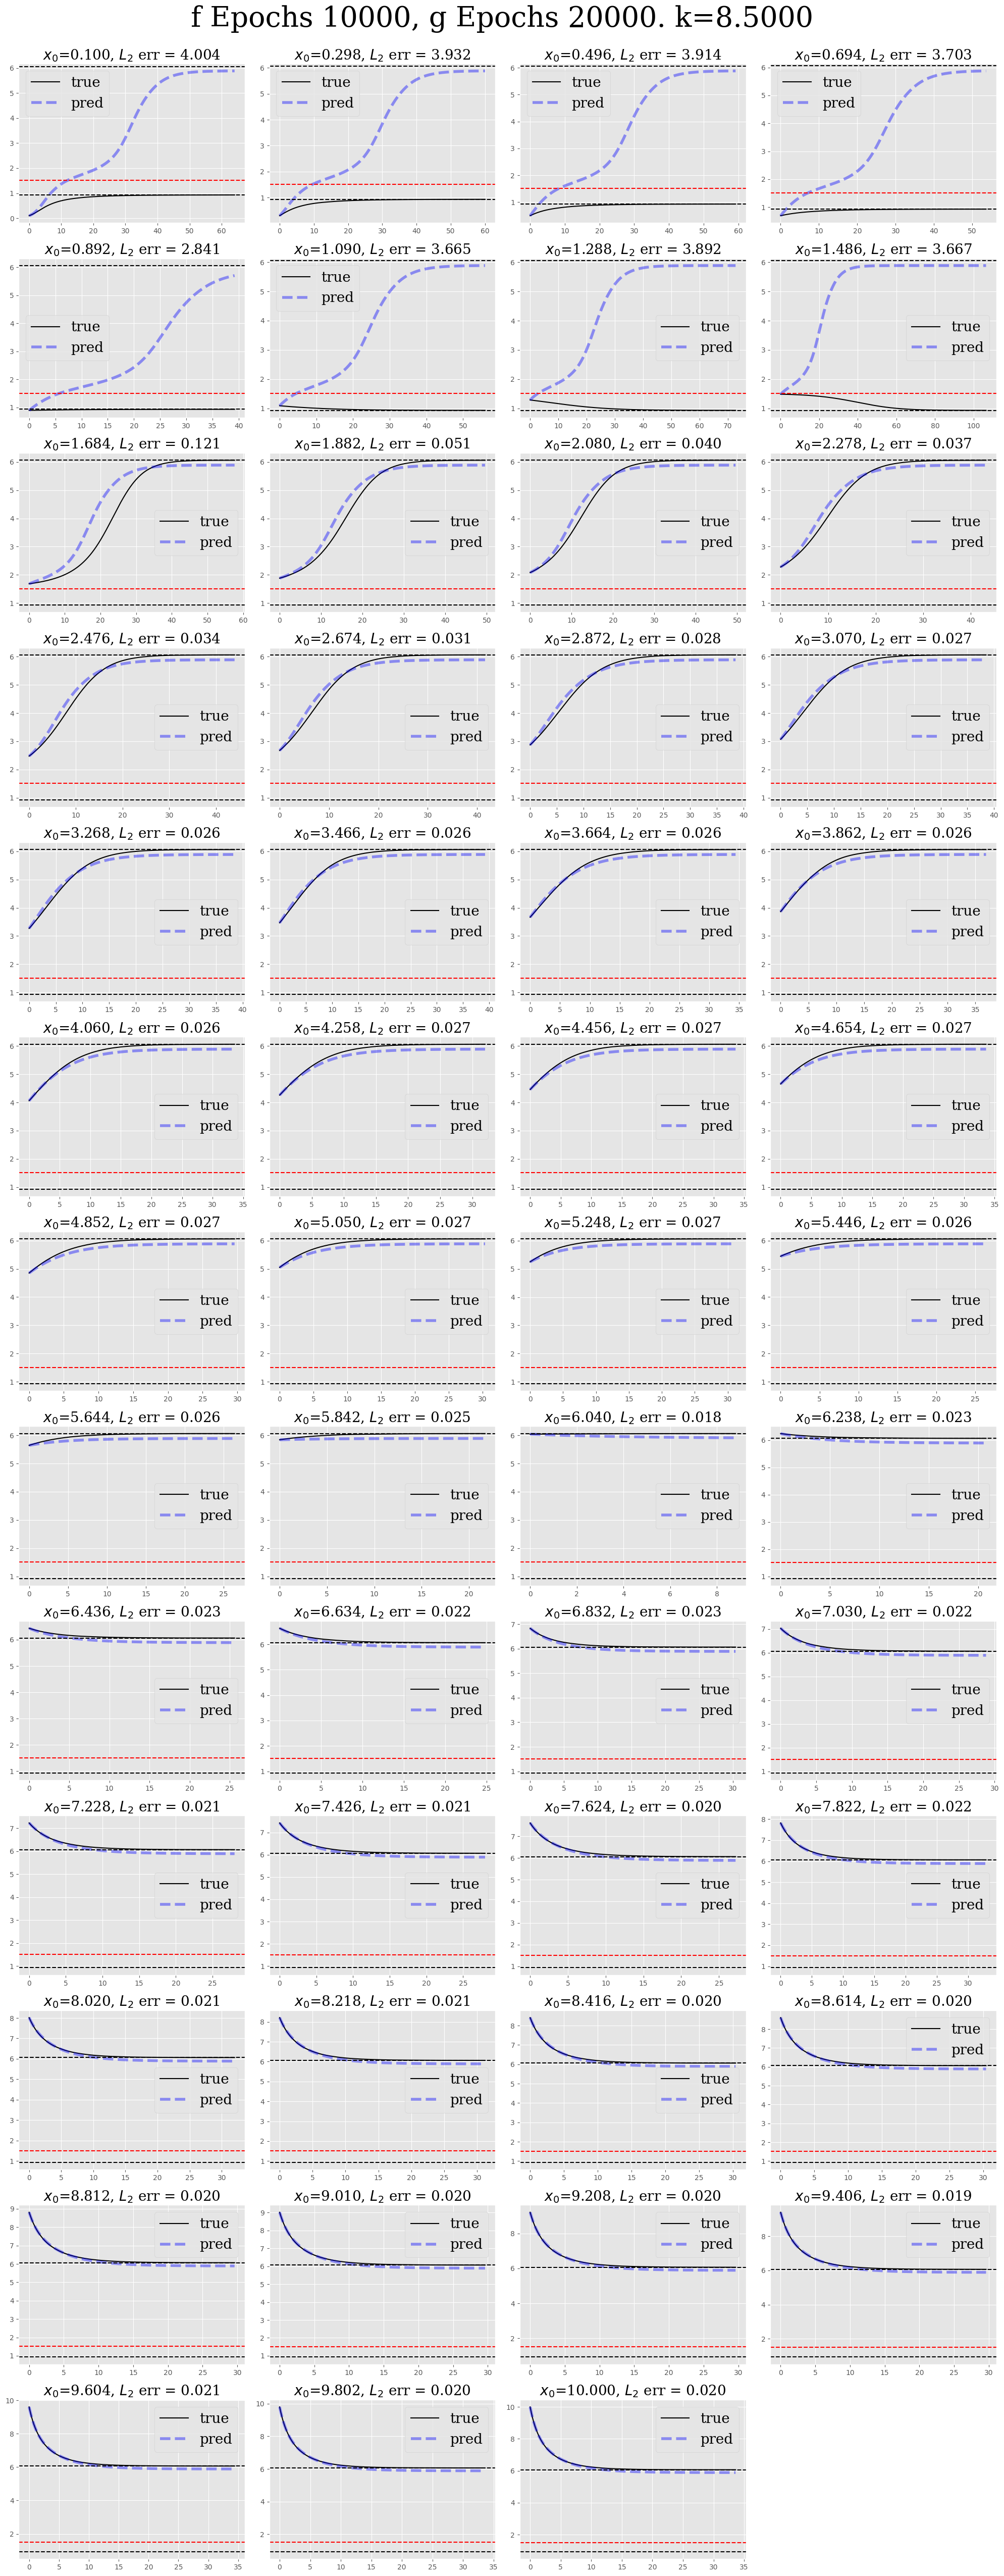

In [31]:
cols = 4
rows = int(np.ceil(len(train_dataset)/cols))

fig, axs = plt.subplots(rows, cols,figsize=(5*cols,4*rows))

axs = axs.flatten()

control_func = lambda t: torch.tensor(k,dtype=torch.float32,device=device).unsqueeze(0)
with torch.no_grad():
    for idx in tqdm(range(len(train_dataset))):
        ax = axs[idx]
        xi, ti, x0i = train_dataset[idx]

        sol = solve_ivp(
            f=lambda t, x: model_eval(t, x, control_func),
            y0=x0i.reshape(-1,1),
            t_eval=ti,
            method=solve_method
        )

        rel_l2_err = np.linalg.norm(sol.ys.squeeze() - xi)/np.linalg.norm(xi)

        ax.plot(ti,xi,label='true',color='black')
        ax.plot(sol.ts.squeeze(),sol.ys.squeeze(),label="pred", linestyle='--', color='blue',alpha=0.4,lw=4)
        # ax.set_ylim(0,1)
        ax.set_title(rf"$x_0$={x0i:.3f}, $L_2$ err = {rel_l2_err:.3f}", family='serif',size=20)
        ax.legend(prop={'family':'serif','size':20})

        for idx,xsi in enumerate(budworm_steady_states(k,r=0.56)):
            label = rf"steady state. $x_s=${xsi:.3f}"
            color = 'black'
            if idx ==1:
                label = rf"unsteady state. $x_s=${xsi:.3f}"
                color = 'red'

            ax.axhline(
                xsi,
                xmin=0,
                c=color,
                linestyle="--",
                label=label,
                zorder=2
            )

    for idx in range(len(train_dataset), rows*cols):
        fig.delaxes(axs[idx])

plt.suptitle(f"f Epochs {f_epochs}, g Epochs {g_epochs}. k={k:.4f}", size=40, family='serif')
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
if savefigs:
    name = f"torchode_solveivp_k_{k:.4f}_f_epochs_{f_epochs}_g_epochs_{g_epochs}.pdf"
    plt.savefig(folder + "/"+name)
plt.show()

## Try `torchdiffeq.odeint` to see outputs

In [32]:
from torchdiffeq import odeint

  0%|          | 0/51 [00:00<?, ?it/s]

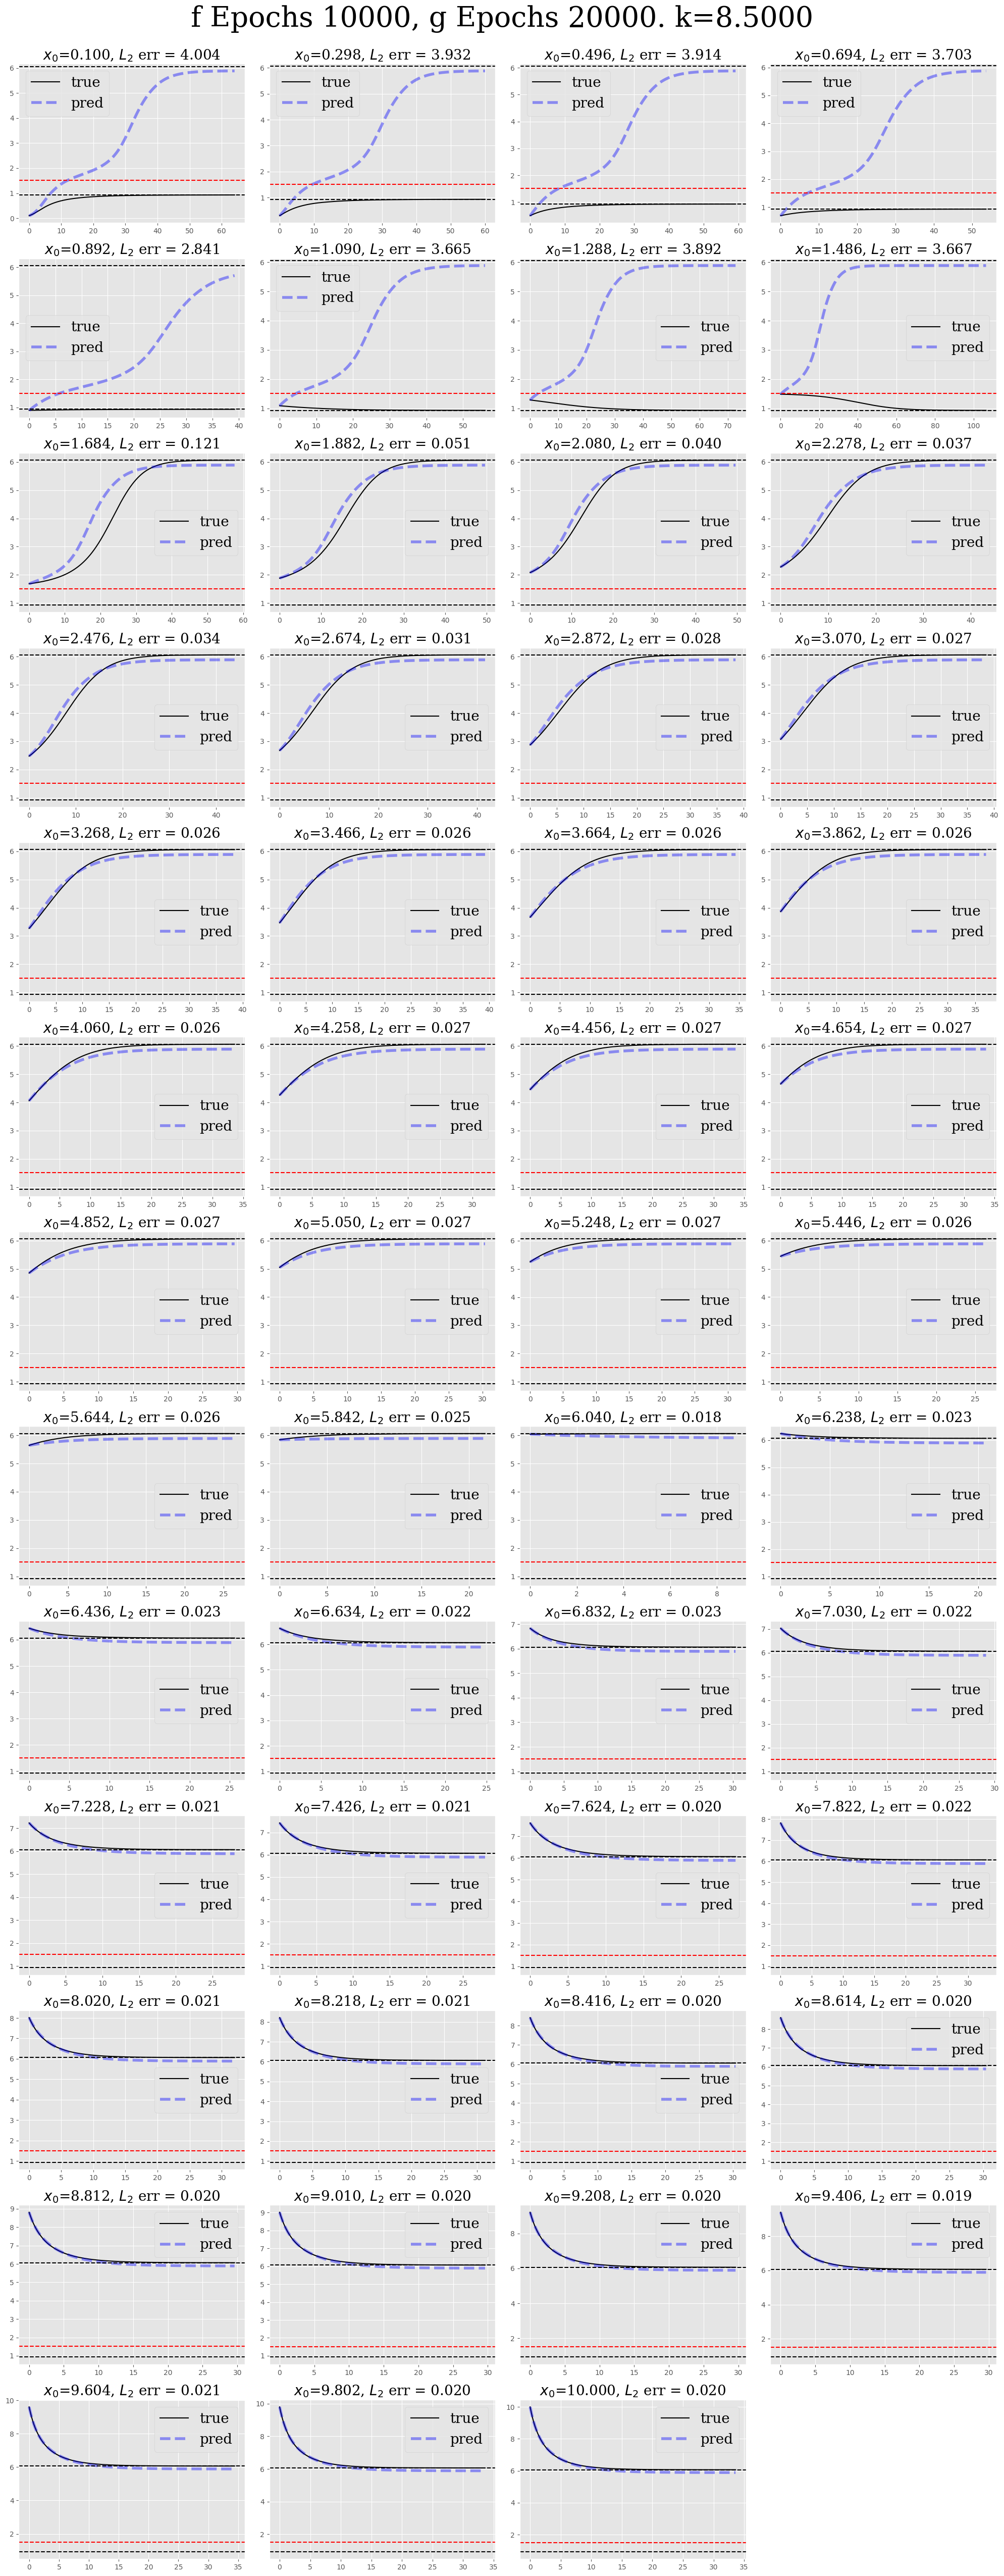

In [36]:
cols = 4
rows = int(np.ceil(len(train_dataset)/cols))

fig, axs = plt.subplots(rows, cols,figsize=(5*cols,4*rows))

axs = axs.flatten()

control_func = lambda t: torch.tensor(k,dtype=torch.float32,device=device).unsqueeze(0)
with torch.no_grad():
    for idx in tqdm(range(len(train_dataset))):
        ax = axs[idx]
        xi, ti, x0i = train_dataset[idx]

        # sol = solve_ivp(
        #     f=lambda t, x: model_eval(t, x, control_func),
        #     y0=x0i.reshape(-1,1),
        #     t_eval=ti,
        #     method=solve_method
        # )

        xi_pred = odeint(
            func = lambda t,x: model_eval(t,x,control_func),
            y0=x0i.reshape(-1,1),
            t=ti,
            # method=solve_method,
        )

        xi_pred = xi_pred.squeeze()
        rel_l2_err = np.linalg.norm(xi_pred - xi)/np.linalg.norm(xi)

        ax.plot(ti,xi,label='true',color='black')
        ax.plot(ti,xi_pred,label="pred", linestyle='--', color='blue',alpha=0.4,lw=4)
        # ax.set_ylim(0,1)
        ax.set_title(rf"$x_0$={x0i:.3f}, $L_2$ err = {rel_l2_err:.3f}", family='serif',size=20)
        ax.legend(prop={'family':'serif','size':20})

        for idx,xsi in enumerate(budworm_steady_states(k,r=0.56)):
            label = rf"steady state. $x_s=${xsi:.3f}"
            color = 'black'
            if idx ==1:
                label = rf"unsteady state. $x_s=${xsi:.3f}"
                color = 'red'

            ax.axhline(
                xsi,
                xmin=0,
                c=color,
                linestyle="--",
                label=label,
                zorder=2
            )

    for idx in range(len(train_dataset), rows*cols):
        fig.delaxes(axs[idx])

plt.suptitle(f"f Epochs {f_epochs}, g Epochs {g_epochs}. k={k:.4f}", size=40, family='serif')
plt.tight_layout(rect=[0, 0, 1, 0.98]) 
if savefigs:
    name = f"torchdiffeq_odeint_k_{k:.4f}_f_epochs_{f_epochs}_g_epochs_{g_epochs}.pdf"
    plt.savefig(folder + "/"+name)
plt.show()